# Current voltage curves

**Pre-requisite: Ramps**

In ramps, smallest possible step size (with highest possible averages) is automatically chosen. In this notebook, parameterization of the [measureIEStairs()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureIEStairs) is discussed. With [measureIEStairs()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureIEStairs) the step size in a ramp can be defined.

In the following examples a step function is used, where depending on the operating mode, potentiostatic or galvanostatic mode, the steps are measured with fixed voltage or current.

At each level, only the last step is saved. This function is relatively slow, one step must be **several 100 ms** long.

The following curves are therefore called **staircase** for the exact differentiation of the ramps, since both ramps and staircases can be used to measure current voltage curves. 

**The step may be terminated with the following two possibilities to continue with the next step:**  
* Change of the complementary value to the control value, with a minimum time
* Maximum time

In addition, the functional and safety limits apply again, as explained in Ramps notebook.

The measurements carried out in this notebook do not necessarily have to make sense from an electrochemical point of view. The only purpose they serve is to explain the configuration of primitives and their different applications.

In [1]:
from zahner_potentiostat.scpi_control.searcher import SCPIDeviceSearcher
from zahner_potentiostat.scpi_control.serial_interface import SerialCommandInterface, SerialDataInterface
from zahner_potentiostat.scpi_control.control import *
from zahner_potentiostat.scpi_control.datahandler import DataManager
from zahner_potentiostat.scpi_control.datareceiver import TrackTypes
from zahner_potentiostat.display.dcplot import DCPlot
from zahner_potentiostat.display.onlinedisplay import OnlineDisplay

from jupyter_utils import executionInNotebook, notebookCodeToPython
if __name__ == '__main__':
    deviceSearcher = SCPIDeviceSearcher()
    deviceSearcher.searchZahnerDevices()
    commandSerial, dataSerial = deviceSearcher.selectDevice()
    ZahnerXPOT2 = SCPIDevice(SerialCommandInterface(commandSerial), SerialDataInterface(dataSerial))
    ZahnerXPOT2.clearState()

COM14:
ZAHNER-ELEKTRIK,XPOT2,27000,1.0.1 binary

COM13:
ZAHNER-ELEKTRIK,XPOT2,27000,1.0.1



# Setting general parameters
First of all, general parameters are set, which will be used in all primitives.

In [2]:
    ZahnerXPOT2.setRaiseOnErrorEnabled(True)
    ZahnerXPOT2.calibrateOffsets()
    ZahnerXPOT2.setSamplingFrequency(50)
    
    ZahnerXPOT2.setAutorangingEnabled(True)
    ZahnerXPOT2.setInterpolationEnabled(True)
    
    ZahnerXPOT2.setShuntIndex(1)
    ZahnerXPOT2.setVoltageRangeIndex(0)

'ok\n'

# Starting the live data display

With the following command, a plotting window can be opened, in which the measured voltage and current points from the measuring device are displayed live.

The function executionInNotebook() is used to check if the execution is taking place in Jupyter notebook or not. As Jupyter cannot display the live measured data so if the execution take place in Jupyter notebook then the online display will not be executed.

In [3]:
    onlineDisplay = None
    if executionInNotebook() == False:
        onlineDisplay = OnlineDisplay(ZahnerXPOT2.getDataReceiver(), displayConfiguration="UlogI")

# Potentiostatic staircase

For this example, the forward characteristic is determined on a diode.

## Setting the potentiostatic measurement.

In order to measure with a defined voltage, potentiostatic operation is set first.

In [4]:
    ZahnerXPOT2.setCoupling(COUPLING.POTENTIOSTATIC)
    ZahnerXPOT2.setVoltageRelation(RELATION.ZERO)
    ZahnerXPOT2.setVoltageParameterRelation(RELATION.ZERO)

'ok\n'

## Setting the start voltage

Like ramps, the stairs start at the actual voltage. Since a diode has no OCV voltage, the measurement is started at 0 V.

In [5]:
    ZahnerXPOT2.setVoltageValue(0)

'ok\n'

## Setting the current limits

The XPOT2 can handle a maximum of 0.5 amps of current, so the currents for the functional interrupts are set accordingly.

In [6]:
    ZahnerXPOT2.setMinimumCurrentParameter(-0.5)
    ZahnerXPOT2.setMaximumCurrentParameter(+0.5)
    ZahnerXPOT2.setMinMaxCurrentParameterCheckEnabled(True)

'ok\n'

## Setting the tolerance limits and maximum time

As the diode heats up, the current increases at a constant voltage across the diode, so a change tolerance of 0.1% of the value at the start of the step per second is specified.  
The tolerance is explained in detail in the notebook Polarizations.ipynb.

The measurement should take a maximum of 10 seconds per step.

In [7]:
    ZahnerXPOT2.setAbsoluteTolerance(0.000)
    ZahnerXPOT2.setRelativeTolerance(0.001)
    ZahnerXPOT2.setToleranceBreakEnabled(True)
    
    ZahnerXPOT2.setMinimumTimeParameter(1)
    ZahnerXPOT2.setMaximumTimeParameter(10)

'ok\n'

## Setting the step size and the target voltage

The step size is set to 50 mV. A normal silicon diode with about 0.7 V forward voltage is used, so 2 V is simply set as the target voltage, but this 2 V is never reached, since the functional termination is 0.5 A maximum device current.

In [8]:
    ZahnerXPOT2.setStepSize(0.01)
    ZahnerXPOT2.setVoltageParameter(2)

'ok\n'

## Execute the primitives

The parameterized stair is executed with the method [measureIEStairs()](https://doc.zahner.de/zahner_potentiostat/scpi_control/control.html#zahner_potentiostat.scpi_control.control.SCPIDevice.measureIEStairs).

In [9]:
    ZahnerXPOT2.measureIEStairs()

'ok\n'

## Plot the data

The data also contains the last point at which the program stops, which is above the set limit of 500 mA.

Whenever a primitive terminates, the last point is stored.

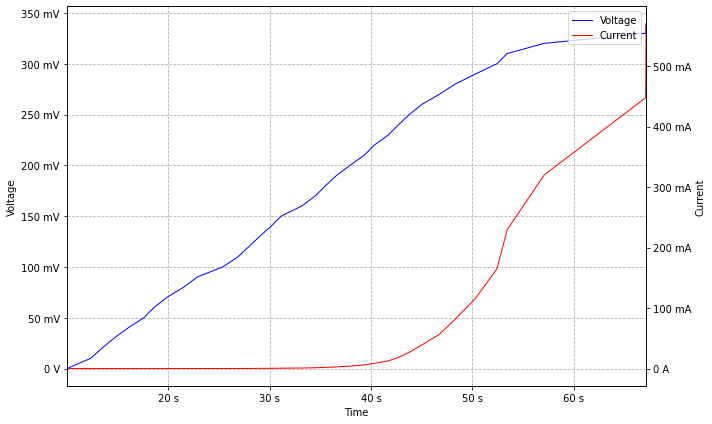

<Figure size 432x288 with 0 Axes>

In [10]:
    dataReceiver = ZahnerXPOT2.getDataReceiver()
    dataManager = DataManager(dataReceiver)
    dataManager.plotTIUData()

## Plot the current voltage curve

There is no standard function for plotting voltage versus current.  
This can be done completely independently or with the DCPlot class.

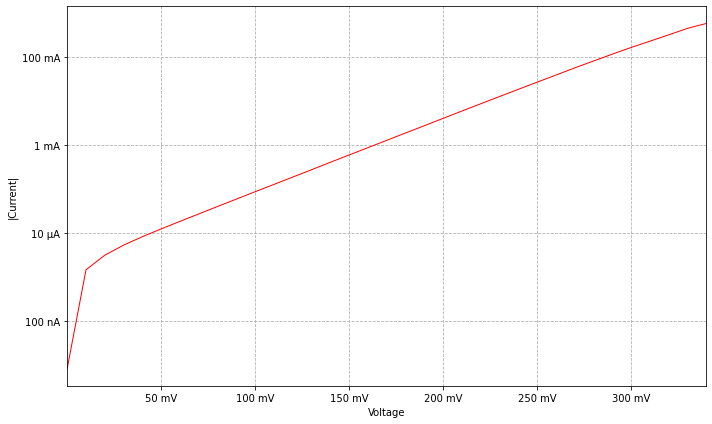

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [11]:
    completeData = dataReceiver.getCompletePoints() 
    voltageData = completeData[TrackTypes.VOLTAGE.toString()]
    currentData = completeData[TrackTypes.CURRENT.toString()]
    
    display = DCPlot("Current voltage curve", "Voltage", "V", [{"label": "Current", "unit": "A", "name": "Current", "log": True}],[voltageData, [currentData]])
    display.savePlot("current_voltage_curve.pdf")

## Reset configurations

The configurations, which are not needed for the next example, are reset to the default.

In [12]:
    dataReceiver.deletePoints()
    ZahnerXPOT2.setMinMaxCurrentParameterCheckEnabled(False)

'ok\n'

# Galvanostatic staircase

For this example, the forward characteristic is determined on a diode.  

In [13]:
    ZahnerXPOT2.setCoupling(COUPLING.GALVANOSTATIC)
    ZahnerXPOT2.setCurrentValue(0)

'ok\n'

## Setting the tolerance limits and maximum time

Now each step should be exactly 1 s long. To prevent an earliers turning off of the potentiostat, the tolerance check is switched off.

In [14]:
    ZahnerXPOT2.setToleranceBreakEnabled(False)
    ZahnerXPOT2.setMaximumTimeParameter(1)

'ok\n'

## Setting the step size and the target voltage

The step size is set to 10 mA and the target current to 500 mA.

In [15]:
    ZahnerXPOT2.setStepSize(0.01)
    ZahnerXPOT2.setCurrentParameter(0.5)

'ok\n'

## Execute the primitives

In [16]:
    ZahnerXPOT2.measureIEStairs()

'ok\n'

## Plot the data

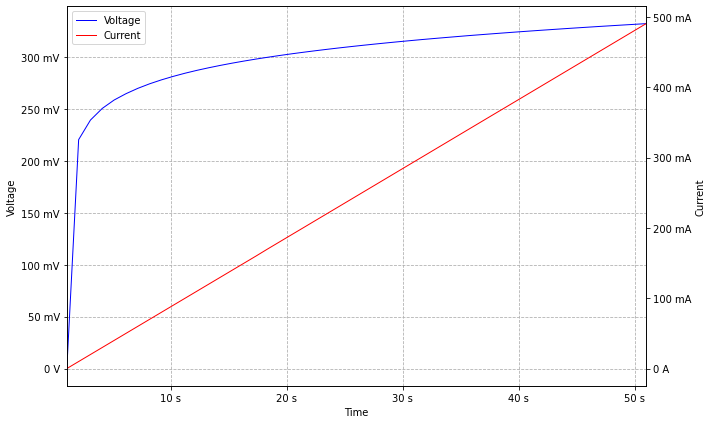

<Figure size 432x288 with 0 Axes>

In [17]:
    dataManager.plotTIUData()

# Close the connection

Closing the online display when it has been opened and close the connection to the device.

In [18]:
    if onlineDisplay != None:
        onlineDisplay.close()
    
    ZahnerXPOT2.close()
    print("finish")

finish


# Deployment of the source code

**The following instruction is not needed by the user.**

It automatically extracts the pure python code from the jupyter notebook to provide it for the user.  
Thus the user does not need jupyter itself and does not have to copy the code manually.

The code is stored in a notebook-like file with the extension .py.

In [19]:
    if executionInNotebook() == True:
        notebookCodeToPython("CurrentVoltageStepCurve.ipynb")